# Rules

In [ ]:
#| default_exp rules
%load_ext autoreload
%autoreload 2

### Overview
...

### Requirements

In [ ]:
#| export
from networkx import DiGraph
from graph_rewrite.match_class import *
from typing import *
from graph_rewrite.core import GraphRewriteException, NodeName, EdgeName, _create_graph, _plot_graph

### Rules Definition

In [ ]:
#| export
class Rule:
    def __init__(self, lhs: DiGraph, p: DiGraph = None, rhs: DiGraph = None):
        self.lhs = lhs
        # self.p = p if p else DiGraph()
        self.p = p if p else self.lhs.copy()
        self.rhs = rhs if rhs else self.p.copy()
        
        self.p_to_lhs, self.p_to_rhs = {}, {}
        self.merge_sym, self.clone_sym = '&', '*'
        self._create_p_lhs_hom()
        self._create_p_rhs_hom()

        self.rev_p_lhs = self._reversed_dictionary(self.p_to_lhs)
        self.rev_p_rhs = self._reversed_dictionary(self.p_to_rhs)
        self._validate_rule()

    # Utils
    def _create_p_lhs_hom(self):
        for p_node in self.p.nodes():
            if self.clone_sym in str(p_node):
                if len(str(p_node).split(self.clone_sym)) == 2:
                    lhs_node, copy_num = str(p_node).split(self.clone_sym)
                    if lhs_node not in self.lhs.nodes():
                        raise GraphRewriteException(f"Node {p_node} clones an non-existing node {lhs_node}.")
                    elif not copy_num.isnumeric():
                        raise GraphRewriteException(f"Node {p_node} clone id {copy_num} is illegal.")
                    else:
                        self.p_to_lhs[p_node] = lhs_node
                else:
                    raise GraphRewriteException(f"Node {p_node} has a bad formatted name.")
            elif p_node in self.lhs.nodes():
                self.p_to_lhs[p_node] = p_node
            else:
                raise GraphRewriteException(f"Node {p_node} in P does not exist in LHS.")

    def _create_p_rhs_hom(self):
        for rhs_node in self.rhs.nodes():
            if self.merge_sym in str(rhs_node):
                if len(str(rhs_node).split(self.merge_sym)) > 1:
                    p_nodes = str(rhs_node).split(self.merge_sym)
                    if all([p_node in self.p.nodes() for p_node in p_nodes]):
                        for p_node in p_nodes:
                            self.p_to_rhs[p_node] = rhs_node
                    else:
                        raise GraphRewriteException(f"Node {rhs_node} merges at least one non-existing P node.")
        for p_node in self.p.nodes():
            if p_node not in self.p_to_rhs.keys():
                if p_node in self.rhs.nodes():
                    self.p_to_rhs[p_node] = p_node
                else:
                    raise GraphRewriteException(f"Node {p_node} in P does not exist in RHS, nor merges into an RHS node.")

    def _reversed_dictionary(self, dictionary: dict) -> dict[Any, set]:
        """Given a dictionary, return a dictionary which maps every
        value from the original dictionary to the set of keys 
        that are mapped to it.

        E.g., for {1: 'a', 2: 'a', 3: 'b'}, the reversing function
        returns {'a': {1,2}, 'b': {3}}.

        Args:
            dictionary (dict): A dictionary to reverse

        Returns:
            dict[Any, set]: A reversed dictionary as described
        """
        rev_dict: dict[Any, set] = {}
        for key, value in dictionary.items():
            if value not in rev_dict:
                rev_dict[value] = set()
            rev_dict[value].add(key)
        return rev_dict

    def _keys_from_val(self, dictionary: dict[Any, set], key) -> set:
        return dictionary[key] if key in dictionary else set()

    def _dict_key_difference(self, dict1: dict, dict2: dict) -> set:
        """Given two dictionaries, find all keys that appear in the first dictionary
        but not in the second one.

        Args:
            dict1 (dict): A dictionary
            dict2 (dict): A dictionary

        Returns:
            set: A set of all keys that appear in the first dictionary but not in the second.
        """
        return set(dict1.keys()) - set(dict2.keys())

    def _validate_rule(self):
        pass # TODO

    # The following functions are presented in the order of transformation.
    def nodes_to_clone(self) -> dict[NodeName, set[NodeName]]:
        """Find all nodes in LHS that should be cloned in P, and for each node, find all its clones.

        These nodes are all nodes in LHS which are mapped by more than one node in P (in the P->LHS Hom.).
        Each such node in P is a clone of the node in RHS which it maps.

        Returns:
            dict[NodeName, set[NodeName]]:
                A dictionary which maps each cloned node in LHS to a set
                of all nodes in P which are its clones.
        """
        return {lhs_node: self.rev_p_lhs[lhs_node] for lhs_node in self.lhs.nodes() \
                            if len(self._keys_from_val(self.rev_p_lhs, lhs_node)) > 1}

    def nodes_to_remove(self) -> set[NodeName]:
        """Find all nodes that should be removed.

        These nodes are all nodes in LHS which are not mapped by any node in P (in the P->LHS Hom.).

        Returns:
            set[NodeName]: Nodes in LHS which should be removed.
        """
        return {lhs_node for lhs_node in self.lhs.nodes() if len(self._keys_from_val(self.rev_p_lhs, lhs_node)) == 0}

    def edges_to_remove(self) -> set[EdgeName]:
        """Find all edges that should be removed (other than edges connected to removed nodes).

        These edges are all edges (s,t) in LHS, or edges (s',t') such that s', t' clone s, t in P respectively,
        which are not in P.

        Note that we do not include edges which one of their endpoints was removed by the rule,
        as during transformation, we begin by removing all removed nodes along with the connected edges.

        Returns:
            set[EdgeName]: Edges in LHS which should be removed.
        """
        edges_to_remove = set()
        for s, t in self.lhs.edges():
            s_copies, t_copies = self._keys_from_val(self.rev_p_lhs, s), self._keys_from_val(self.rev_p_lhs, t)
            if len(s_copies) == 0 or len(t_copies) == 0: # one of the endpoints was removed
                continue # don't count this edge
            for s_copy in s_copies:
                for t_copy in t_copies:
                    if (s_copy, t_copy) not in self.p.edges():
                        edges_to_remove.add((s_copy, t_copy))
        return edges_to_remove

    def node_attrs_to_remove(self) -> dict[NodeName, set]:
        """For each node in P, find all attributes of its corresponding LHS node
        which should be removed from the P node.

        For a pair (node_lhs, node_p), such that node_p is a copy of node_lhs in P,
        these attributes are all attributes that appear in node_lhs but not in node_p.

        Returns:
            dict[NodeName, set]: A dictionary from P nodes to attributes that should be
                removed from their corresponding LHS nodes.
        """
        attrs_to_remove = {}
        for node_lhs in self.lhs.nodes():
            p_copies = self._keys_from_val(self.rev_p_lhs, node_lhs)
            for node_p in p_copies:
                diff_attrs = self._dict_key_difference(
                    self.lhs.nodes(data=True)[node_lhs],
                    self.p.nodes(data=True)[node_p]
                )
                if len(diff_attrs) != 0:
                    attrs_to_remove[node_p] = diff_attrs
        return attrs_to_remove

    def edge_attrs_to_remove(self) -> dict[EdgeName, set]:
        """For each edge in P, find all attributes of its corresponding LHS edge
        which should be removed from the P edge.

        Returns:
            dict[EdgeName, set]: A dictionary from P edges to attributes that should be
                removed from their corresponding LHS edges.
        """
        attrs_to_remove = {}
        for s, t in self.lhs.edges():
            s_copies, t_copies = self._keys_from_val(self.rev_p_lhs, s), self._keys_from_val(self.rev_p_lhs, t)
            for s_copy in s_copies:
                for t_copy in t_copies:
                    if (s_copy, t_copy) in self.p.edges():
                        diff_attrs = self._dict_key_difference(
                            self.lhs.get_edge_data(s, t),
                            self.p.get_edge_data(s_copy, t_copy),
                        )
                        if len(diff_attrs) != 0:
                            attrs_to_remove[(s_copy, t_copy)] = diff_attrs
        return attrs_to_remove

    def nodes_to_merge(self) -> dict[NodeName, set[NodeName]]:
        """Find all nodes in RHS which are a merge of nodes in P, and for each node, find all P nodes that merge into it.

        These nodes are all nodes in RHS which are mapped by more than one node in P (in the P->RHS Hom.).
        That RHS node is the merge of all nodes in P that map to it.

        Returns:
            dict[NodeName, set[NodeName]]: 
                A dictionary which maps each node in RHS that is a merge of P nodes,
                to a set of nodes in P which it merges.
        """
        return {rhs_node: self.rev_p_rhs[rhs_node] for rhs_node in self.rhs.nodes() \
                            if len(self._keys_from_val(self.rev_p_rhs, rhs_node)) > 1}

    def nodes_to_add(self) -> set[NodeName]:
        """Find all nodes which should be added.

        These nodes are all nodes in RHS which are not mapped by any node in P (in the P->LHS Hom.).

        Returns:
            set[NodeName]: Nodes which should be added to RHS.
        """
        return {rhs_node for rhs_node in self.rhs.nodes() if len(self._keys_from_val(self.rev_p_rhs, rhs_node)) == 0}

    def edges_to_add(self) -> set[EdgeName]:
        """Find all edges that should be added.

        These edges are all edges (s,t) in RHS that do not appear in P,
        which are NOT edges (s,t) that were created by a merge.

        Returns:
            set[EdgeName]: Edges which should be added to RHS.
        """
        edges_to_add = set()
        for s, t in self.rhs.edges():
            s_copies, t_copies = self._keys_from_val(self.rev_p_rhs, s), self._keys_from_val(self.rev_p_rhs, t)
            if len(s_copies) == 0 or len(t_copies) == 0: # edge with new endpoint(s)
                edges_to_add.add((s,t)) # surely a new edge
            # Edges that were created by merging OR New edges from existing nodes
            elif all([(s_copy, t_copy) not in self.p.edges() for s_copy in s_copies for t_copy in t_copies]):
                edges_to_add.add((s,t))

        return edges_to_add

    def node_attrs_to_add(self) -> dict[NodeName, dict]:
        """For each node in RHS, find all attributes (and values) of its corresponding P node(s)
        which should be added to the RHS node.

        For each RHS node n, if n is an added node then these attributes (and values) are all attributes (and values) of n.
        
        NOTE: Otherwise, n is a merge of one or more nodes in P, then these attributes are the union of all
        attributes of the merged nodes which do not appear in n. Their values are obtained by a dictionary merge,
        on which we did not decide yet.

        Returns:
            dict[NodeName, dict]: A dictionary that maps nodes in RHS to their added attributes and values.
        """
        #TODO: implement
        return {}

    def edge_attrs_to_add(self) -> dict[EdgeName, dict]:
        #TODO: implement
        return {}


### Tests

#### Test Utils

In [ ]:
def _assert_rule(lhs: DiGraph, p: DiGraph = None, rhs: DiGraph = None,
                nodes_clone: dict[NodeName, set[NodeName]] = {},
                nodes_remove: set[NodeName] = set(),
                edges_remove: set[EdgeName] = set(),
                node_attrs_remove: dict[NodeName, set] = {}, 
                edge_attrs_remove: dict[EdgeName, set] = {}, 
                nodes_merge: dict[NodeName, set[NodeName]] = {}, 
                nodes_add: set[NodeName] = set(), 
                edges_add: set[EdgeName] = set(),
                node_attrs_add: dict[NodeName, dict] = {}, 
                edge_attrs_add: dict[EdgeName, dict] = {}):
    rule = Rule(lhs, p=p, rhs=rhs)

    assert rule.nodes_to_clone() == nodes_clone
    assert rule.nodes_to_remove() == nodes_remove
    assert rule.edges_to_remove() == edges_remove
    assert rule.node_attrs_to_remove() == node_attrs_remove
    assert rule.edge_attrs_to_remove() == edge_attrs_remove
    assert rule.nodes_to_merge() == nodes_merge
    assert rule.nodes_to_add() == nodes_add
    assert rule.edges_to_add() == edges_add
    assert rule.node_attrs_to_add() == node_attrs_add
    assert rule.edge_attrs_to_add() == edge_attrs_add

#### Tests

##### Preserve and Remove (Without Attributes)

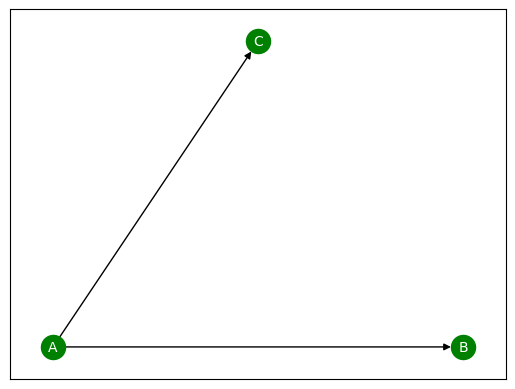

In [ ]:
lhs = _create_graph(['A', 'B', 'C'], [('A','B'), ('A','C')])
_plot_graph(lhs)

In [ ]:
# Rule which does not change a thing
_assert_rule(lhs)

In [ ]:
# Remove all edges
p = _create_graph(['A', 'B', 'C'], [])
_assert_rule(lhs, p=p, edges_remove={('A','B'), ('A','C')})

In [ ]:
# Remove node A (connected edges removed automatically and thus not counted)
p = _create_graph(['B', 'C'], [])
_assert_rule(lhs, p=p, nodes_remove={'A'})

In [ ]:
# Remove node B (and connected edge), also remove (A,C)
p = _create_graph(['A','C'], [])
_assert_rule(lhs, p=p, nodes_remove={'B'}, edges_remove={('A','C')})

##### Clone Nodes

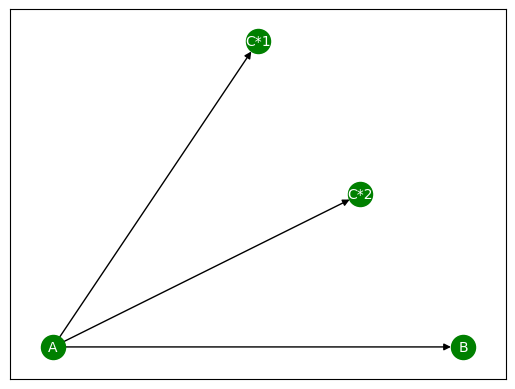

In [ ]:
# Clone node C (connected edges cloned automatically and not counted as added edges, same about added nodes)
p = _create_graph(['A', 'B', 'C*1', 'C*2'], [('A','B'), ('A','C*1'), ('A', 'C*2')])
_plot_graph(p)
_assert_rule(lhs, p=p, nodes_clone={'C': {'C*1', 'C*2'}})

In [ ]:
# Clone node A (3 copies) and B (2 copies)
p = _create_graph(['A', 'B', 'A*3', 'A*5', 'C', 'B*9'], 
                  [('A','B'), ('A', 'B*9'), ('A*3', 'B'), ('A*3', 'B*9'), ('A*5', 'B'), ('A*5', 'B*9'), 
                   ('A', 'C'), ('A*3', 'C'), ('A*5', 'C')])
_assert_rule(lhs, p=p, nodes_clone={'A': {'A', 'A*5', 'A*3'}, 'B': {'B*9', 'B'}})

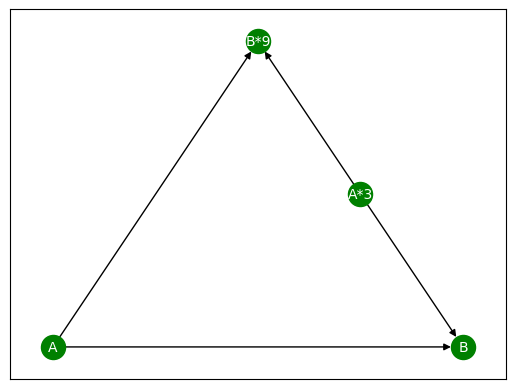

In [ ]:
# Clone node A (2 copies) and B (2 copies), remove node C
p = _create_graph(['A', 'B', 'A*3', 'B*9'], 
                  [('A','B'), ('A', 'B*9'), ('A*3', 'B'), ('A*3', 'B*9')])
_plot_graph(p)
_assert_rule(lhs, p=p, nodes_clone={'A': {'A', 'A*3'}, 'B': {'B*9', 'B'}}, nodes_remove={'C'})

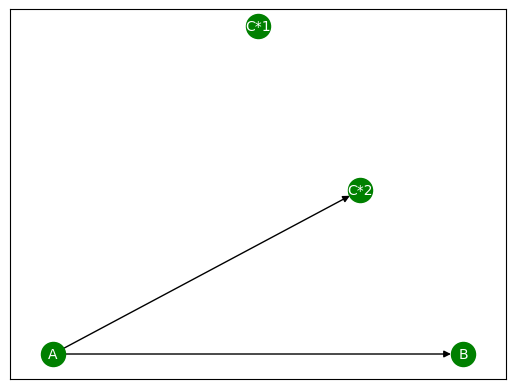

In [ ]:
# Clone node C, exclude cloning the (A,C) edge for clone C*1
p = _create_graph(['A', 'B', 'C*1', 'C*2'], [('A','B'), ('A', 'C*2')])
_plot_graph(p)
_assert_rule(lhs, p=p, nodes_clone={'C': {'C*1', 'C*2'}}, edges_remove={('A','C*1')})

##### Preserve, Remove and Clone (With Attributes)

In [ ]:
lhs = _create_graph(['A', ('B', {'attr_b': 5}), 'C'], [('A','B'), ('A','C', {'attr_ac': 10})])

In [ ]:
# Remove a node / edge with attributes (attributes are not counted as deleted)
p = _create_graph(['A', 'C'], [('A','C', {'attr_ac': 10})])
_assert_rule(lhs, p=p, nodes_remove={'B'})
p = _create_graph(['A', ('B', {'attr_b': 5}), 'C'], [('A','B')])
_assert_rule(lhs, p=p, edges_remove={('A','C')})

In [ ]:
# Remove an attribute from B
p = _create_graph(['A', 'B', 'C'], [('A','B'), ('A','C', {'attr_ac': 10})])
_assert_rule(lhs, p=p, node_attrs_remove={'B': {'attr_b'}})

In [ ]:
# Clone node B with attributes
p = _create_graph(['A', ('B', {'attr_b': 5}), 'C', ('B*1', {'attr_b': 5})],
                  [('A','B'), ('A','B*1'), ('A','C', {'attr_ac': 10})])
_assert_rule(lhs, p=p, nodes_clone={'B': {'B', 'B*1'}})

In [ ]:
# Update LHS with attribute for (A,B), then clone node B with attributes (shouldn't count edges)
lhs = _create_graph(['A', ('B', {'attr_b': 5}), 'C'], [('A','B', {'attr_ab': 12}), ('A','C', {'attr_ac': 10})])
p = _create_graph(['A', ('B', {'attr_b': 5}), 'C', ('B*1', {'attr_b': 5})],
                  [('A','B', {'attr_ab': 12}), ('A','B*1', {'attr_ab': 12}), ('A','C', {'attr_ac': 10})])
_assert_rule(lhs, p=p, nodes_clone={'B': {'B', 'B*1'}})

##### Add Nodes, Edges (Without Attributes)

In [ ]:
lhs = _create_graph(['A', 'B', 'C'], [('A','B'), ('A','C')])

In [ ]:
# Add a new node D
rhs = _create_graph(['A', 'B', 'C', 'D'], [('A','B'), ('A','C')])
_assert_rule(lhs, rhs=rhs, nodes_add={'D'})

In [ ]:
# Add a new edge from existing nodes
rhs = _create_graph(['A', 'B', 'C'], [('A','B'), ('A','C'), ('B','C')])
_assert_rule(lhs, rhs=rhs, edges_add={('B','C')})

In [ ]:
# Add a new node D, a new edge using D and a new edge from existing nodes (with attributes)
rhs = _create_graph(['A', 'B', 'C', 'D'], [('A','B'), ('A','D'), ('A','C'), ('B','C')])
_assert_rule(lhs, rhs=rhs, nodes_add={'D'}, edges_add={('B','C'), ('A','D')})

##### Merge Nodes

In [ ]:
# Merge node B and C (don't count edges and nodes that were added/removed as a result)
rhs = _create_graph(['A', 'B&C'], [('A','B&C')])
_assert_rule(lhs, rhs=rhs, nodes_merge={'B&C': {'B','C'}})

In [ ]:
# Merge node A and B
rhs = _create_graph(['A&B', 'C'], [('A&B','A&B'), ('A&B', 'C')])
_assert_rule(lhs, rhs=rhs, nodes_merge={'A&B': {'A','B'}})

In [ ]:
# Merge node A, B and C
rhs = _create_graph(['A&B&C'], [('A&B&C', 'A&B&C')])
_assert_rule(lhs, rhs=rhs, nodes_merge={'A&B&C': {'A','B','C'}})